In [362]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:65% !important; }</style>"))

In [27]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.io import loadmat
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':1.5}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
figDir = '/Users/aqib/Desktop/BCCL/char-syn-gene-nets/MSB_submission/figures/'

import seaborn as sns
import cvxpy
import time
import scanpy as sc
from copy import deepcopy
from collections import Counter
import re

In [3]:
def concat_metadata2tpmdata(dftpm,dfmd):
    # add the metadata to the tpm data

    # find the rows of the metadata which correspond to the columns of the tpm data
    metalist = list(dfmd['sample_id'])
    dfmd_match_rowInd = []
    dftpm_match_colInd = []
    sid_count = 1
    for sid in dftpm.iloc[:,1:]:
        dfmd_match_rowInd.append(metalist.index(sid))
        dftpm_match_colInd.append(sid_count)
        sid_count = sid_count + 1
    # dfmd.iloc[dfmd_match_rowInd,:]

    # rename the row indices with the gene names
    dftpm_geneindex = dftpm.set_index('gene_id')
    dftpm_geneindex.index.names = [None]
    # dftpm_geneindex

    # create a dataframe, md2append, which contains just the metadata that correponds to the experiments in tpm data
    sids = list(dftpm_geneindex.columns)
    md2append = dfmd.T.iloc[:,dfmd_match_rowInd]
    md2append.columns = sids

    # concatenate the metadata to the top of the columns of tpm data
    dftpm_final = pd.concat([md2append,dftpm_geneindex[:]])
    # dftpm_final
    
    return(dftpm_final)

### Load data and metadata

In [4]:
df_tpm1 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_1.tsv', sep='\t') # replicates 1,2,3,4 if they exist
df_tpm2 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_2.tsv', sep='\t') # replicates 5,6,7,8 if they exist
df_metadata = pd.read_csv('NANDiterate_metadata.csv', sep=',')

In [5]:
df_tpm1_final = concat_metadata2tpmdata(df_tpm1,df_metadata)
df_tpm2_final = concat_metadata2tpmdata(df_tpm2,df_metadata)
df_tpm_final = pd.concat([df_tpm1_final,df_tpm2_final],axis=1)

### Remove samples with NaN values

In [6]:
sample_inds_with_nans = list(set(np.where(np.isnan(np.array(df_tpm_final.iloc[10:,:],dtype=np.float32)))[1]))
sample_with_nans = list(df_tpm_final.columns)[sample_inds_with_nans[0]]
df_tpm_final = df_tpm_final.drop(columns=[sample_with_nans],axis=1)

### Generate AnnData object 

In [7]:
obs_df = df_tpm_final.T.loc[:,['sample_id','timepoint','strain','temperature','replicate',
                               'arabinose_concentration','arabinose_unit','IPTG_concentration',
                               'IPTG_unit','strain_input_state']]
adata = sc.AnnData(np.array(df_tpm_final.T.iloc[:,10:],dtype=np.float32),obs=obs_df)
adata.var_names = list(df_tpm_final.index)[10:]

input_state = []
aras = np.sort(adata.obs.arabinose_concentration.unique())
iptgs = np.sort(adata.obs.IPTG_concentration.unique())
for ii, (ara,iptg) in enumerate(zip(adata.obs.arabinose_concentration,adata.obs.IPTG_concentration)):  

    if ara == aras[0]: 
        input_state.append( '(none,' )
    elif ara == aras[1]:
        input_state.append( '(low,' )
    elif ara == aras[2]:
        input_state.append( '(mid,'  ) 
    elif ara == aras[3]:
        input_state.append( '(high,' )
    
    if iptg == iptgs[0]: 
        input_state[ii] += ' none)'
    elif iptg == iptgs[1]:
        input_state[ii] += ' low)'
    elif iptg == iptgs[2]:
        input_state[ii] += ' mid)'   
    elif iptg == iptgs[3]:
        input_state[ii] += ' high)'
        
adata.obs['strain_input_state'] = input_state
adata.obs['timepoint'] = adata.obs['timepoint'].astype(str)
adata.obs['temperature'] = adata.obs['temperature'].astype(str)

sc.pp.log1p(adata)

### Remove plasmid strains from object

In [8]:
adata = adata[~adata.obs.strain.isin(['MG1655_pJS007_LALT__backbone','MG1655_pJS007_LALT__P3__PhlF',
                                     'MG1655_pJS007_LALT__I1__IcaRA'])].copy()

### Create a new AnnData object without circuit genes

In [9]:
bdata = adata[:,0:-13].copy() # remove circuit genes since they will bias results 

### TF-GENE network

In [10]:
tf_gene_df = pd.read_csv('TF-Gene_network_Ecoli_K12.csv',index_col=0).reset_index(drop=True)

Get list of TFs that are in the RNA-seq dataset

In [11]:
N_ALL_GENES = len(bdata.var_names.tolist()) # n endogenous genes in RNA-seq data
db_TFs = tf_gene_df.regulator.tolist() # list of TFs from RegulonDB
db_TFs = [x[0].lower() + x[1:] for x in db_TFs] # set the TF names to lowercase
TFs = list(set(bdata.var_names.tolist()).intersection(db_TFs)) # get the TFs that are in the RNA-seq data
tf_gene_df = tf_gene_df.loc[list(np.where(pd.DataFrame(db_TFs)[0].isin(TFs))[0])] # subset tf_gene_df accordingly
N_TFs = len(tf_gene_df.regulator.unique()) # n TFs that are in the RNA-seq data

Build the adjacency matrix

In [14]:
tf_adj_df = pd.DataFrame(np.zeros((N_TFs,N_ALL_GENES)))
tf_adj_df = tf_adj_df.set_index(tf_gene_df.regulator.unique())
tf_adj_df.columns = bdata.var_names.tolist()
for ii, tf in enumerate(tf_adj_df.index):
    # get the portion of the df that has 'tf' as regulator
    this_tf_gene = tf_gene_df[tf_gene_df.regulator.isin([tf])] 
    # get the regulated genes for 'tf'
    regulated_genes = this_tf_gene.regulated.tolist()
    # remove any genes that are not in 'tf_adj_df.columns'
    subset_regulated_genes = tf_adj_df.loc[tf,tf_adj_df.columns.isin(regulated_genes)].index.tolist() 
    # get the effect of 'tf' on 'subset_regulated_genes'
    this_tf_gene = this_tf_gene[this_tf_gene.regulated.isin(subset_regulated_genes)]
    # the database may contain duplicate entries, keep only one of them
    dups = [k for (k,v) in Counter(this_tf_gene.regulated.tolist()).items() if v > 1]
    dups_ind = this_tf_gene[this_tf_gene.regulated.isin(dups)].index.tolist()[1:]
    this_tf_gene = this_tf_gene.drop(labels=dups_ind,axis=0)
    # grab the effect labels
    this_effect = this_tf_gene.effect.tolist()
    # change any nan to 0, any '+' to 1, any '-' to -1, and any '+/-' to 2
    this_effect = ['0' if x is np.nan else x for x in this_effect]
    this_effect = ['1' if x == '+' else x for x in this_effect] 
    this_effect = ['-1' if x == '-' else x for x in this_effect]
    this_effect = ['2' if x == '+/-' else x for x in this_effect]    
    this_effect = [int(x) for x in this_effect]
    # write this to the adjacency matrix
    tf_adj_df.loc[tf,subset_regulated_genes] = this_effect

In [15]:
tdata = bdata[:,TFs].copy()

### SIGMA - GENE network

In [16]:
sigma_gene_df = pd.read_csv('network_sigma_gene.txt',sep='\t',header=None).iloc[:,[0,1,2]]
sigma_gene_df.columns = ['regulator','regulated','effect']

In [17]:
sigma_adj_df = pd.DataFrame(np.zeros((len(set(sigma_gene_df['regulator'])),N_ALL_GENES)))
sigma_adj_df = sigma_adj_df.set_index(sigma_gene_df.regulator.unique())
sigma_adj_df.columns = bdata.var_names.tolist()

In [18]:
for ii, sigma in enumerate(sigma_adj_df.index):
    # get the portion of the df that has 'sigma' as regulator
    this_sigma_gene = sigma_gene_df[sigma_gene_df.regulator.isin([sigma])]
    # get the regulated genes for 'sigma'
    regulated_genes = this_sigma_gene.regulated.tolist()
    # remove any genes that are not in 'sigma_adj.columns'
    subset_regulated_genes = sigma_adj_df.loc[sigma,sigma_adj_df.columns.isin(regulated_genes)].index.tolist()
    # get the effect of 'tf' on 'subset_regulated_genes'
    this_sigma_gene = this_sigma_gene[this_sigma_gene.regulated.isin(subset_regulated_genes)]
    # grab the effect labels
    this_effect = this_sigma_gene.effect.tolist()
    # change any nan to 0, any '+' to 1, any '-' to -1, and any '+/-' to 2
    this_effect = ['0' if x is np.nan else x for x in this_effect]
    this_effect = ['1' if x == '+' else x for x in this_effect] 
    this_effect = ['-1' if x == '-' else x for x in this_effect]
    this_effect = ['2' if x == '+/-' else x for x in this_effect]    
    this_effect = [int(x) for x in this_effect]
    # write this to the adjacency matrix
    sigma_adj_df.loc[sigma,subset_regulated_genes] = this_effect

### Essential genes

In [19]:
ess_df = pd.read_csv('deg_annotation_p.csv', sep=';', header=None,quotechar='"')
ess_df.columns = ['organism_id','gene_id','gene','protein_id?','?','biological process',
                   'biological function','bacteria','genome_ref','media','locus_tag','GO_id','??','???']
essential_genes = list(set(ess_df[ess_df.bacteria.isin(['Escherichia coli MG1655 I'])].gene))
# many of genes come as a pair of genes in a single string 'gene1/gene2', separate them
essential_genes_new = []
for gene in essential_genes:
    if '/' in gene: 
        two_genes = gene.split('/')
        essential_genes_new += two_genes
    else: 
        essential_genes_new.append(gene)
essential_genes = essential_genes_new
essential_genes = list(set(essential_genes).intersection(list(bdata.var_names)))
edata = bdata[:,essential_genes].copy()

### Plot interesting genes in a heatmap
These markers came from preliminary analysis. 

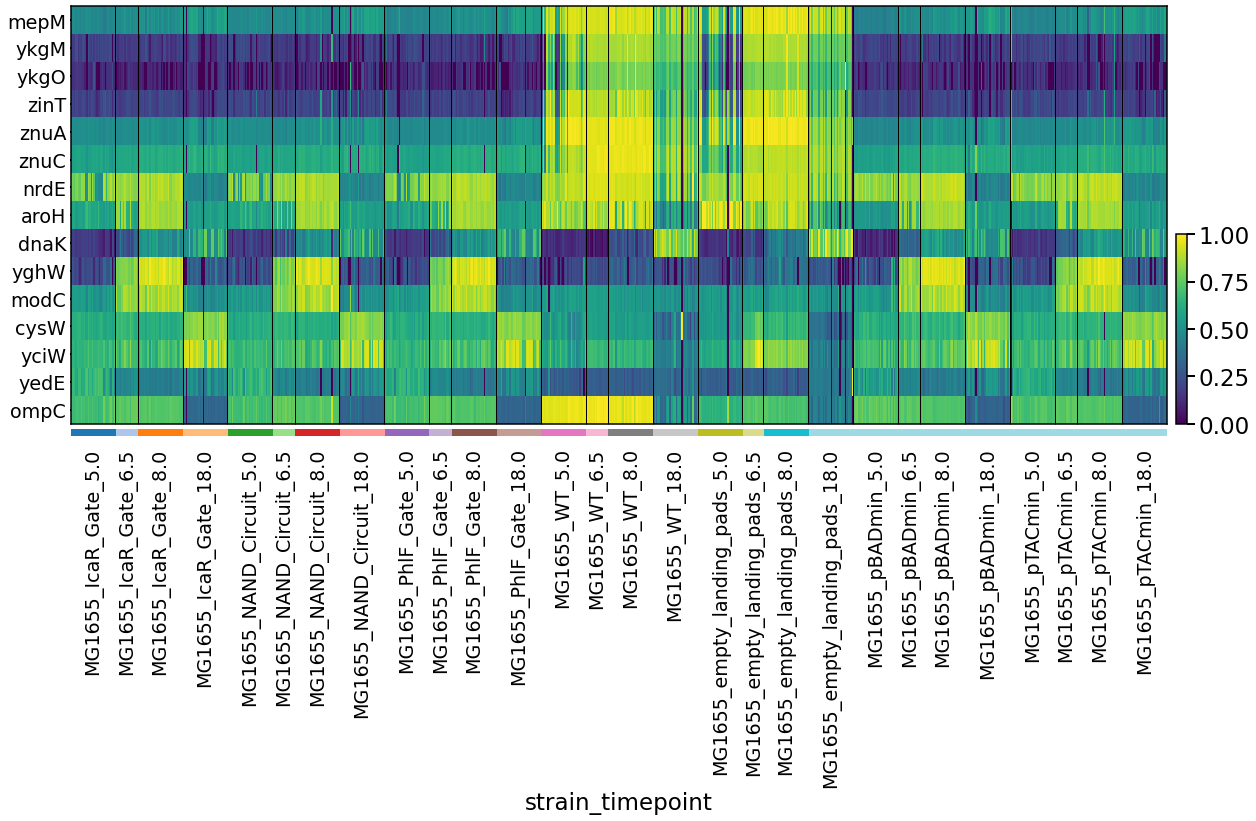

In [385]:
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 

circuit_markers = ['mepM','ykgM','ykgO','zinT','znuA','znuC','nrdE','aroH','dnaK','yghW','modC',
                   'cysW','yciW','yedE','ompC']
fig = sc.pl.heatmap(adata, var_names=circuit_markers, 
              groupby=['strain','timepoint'],
              swap_axes=True,figsize=(20,8),
              cmap='viridis',standard_scale='var',dendrogram=False)

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 

### mepM is interesting! 
Using STRING-DB (https://string-db.org/cgi/network?taskId=b1PSR9GvKaDD&sessionId=bdIHtsFSnaBV) we can identify associated genes. Plot those along with mepM

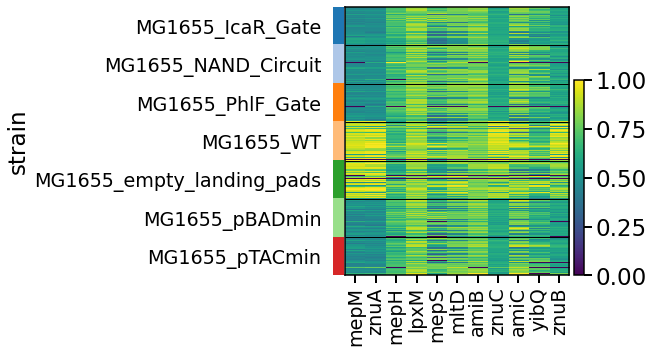

In [99]:
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 

circuit_markers = ['mepM','znuA','mepH','lpxM','mepS','mltD','amiB','znuC','amiC','yibQ','znuB']
fig = sc.pl.heatmap(adata, var_names=circuit_markers, 
              groupby=['strain'],
              swap_axes=False,figsize=(4.5,5),
              cmap='viridis',standard_scale='var') # ,save='_mepM-network.pdf'

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 

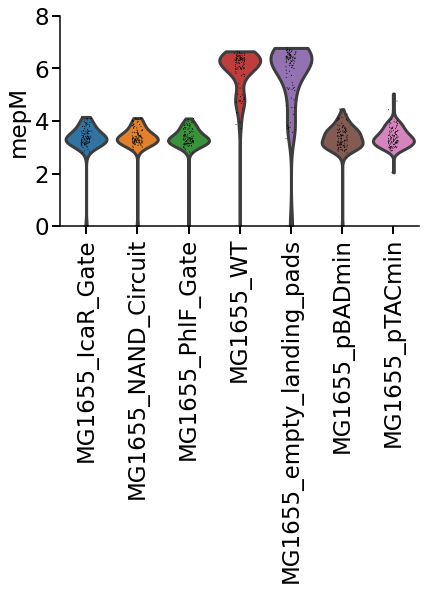

In [402]:
# group by strain and plot mepM

plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 

sc.pl.violin(adata,keys=['mepM'],groupby='strain',rotation=90) # ,save='_mepM.pdf'

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 

In [254]:
# which genes are correlated with mepM (use bdata so as not to correlate with circuit genes)
tpm_df = pd.DataFrame(bdata.X,columns=bdata.var_names.tolist())
corr_mepM = np.array(tpm_df.corrwith(tpm_df['mepM']))

corr_cutoff = 0.6
mepM_corr_genes = list(bdata.var_names[np.where(np.abs(corr_mepM) >= corr_cutoff)[0]]) 
# want mepM to come first in list
mepM_corr_genes = ['mepM'] + mepM_corr_genes
mepM_corr_genes = list(dict.fromkeys(mepM_corr_genes)) 

# make a correlation heatmap with just these genes
corr_mepM = tpm_df[mepM_corr_genes].corr()

# sort by descending correlation
mepM_corr_genes = corr_mepM.sort_values(by=['mepM'],ascending=False)['mepM'].index.tolist()

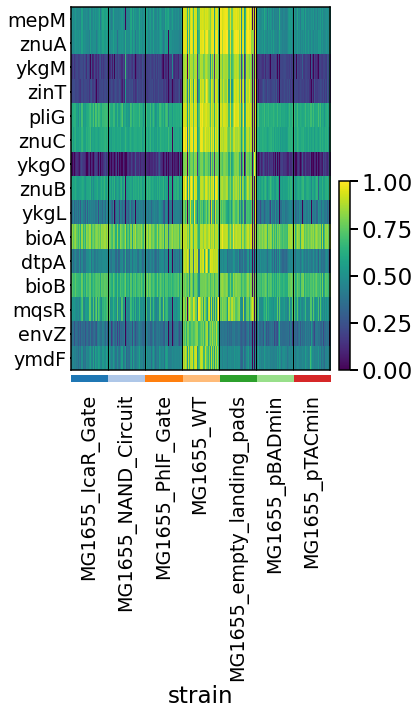

In [259]:
plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 

fig = sc.pl.heatmap(adata, var_names=mepM_corr_genes, 
              groupby=['strain'],
              swap_axes=True,figsize=(5,7),
              cmap='viridis',standard_scale='var') # ,save='_mepM-corr.pdf'

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 

This also implies that there are no inversely correlated genes to the mepM profile. Meaning there are no genes which are ON in the circuit case and OFF in the WT/empty case. Interesting.

### NAND iterate growth curves

In [22]:
nand_od = loadmat('GrowthCurves/NAND1_GCs.mat')['A']
wt_mean = np.mean(nand_od[:,[9,21,33,45]],axis=1) # no induction for all curves below
wt_std = np.std(nand_od[:,[9,21,33,45]],axis=1)
phlf_mean = np.mean(nand_od[:,[0,12,24,36]],axis=1) 
phlf_std = np.std(nand_od[:,[0,12,24,36]],axis=1) 
icar_mean = np.mean(nand_od[:,[1,13,25,37]],axis=1) 
icar_std = np.std(nand_od[:,[1,13,25,37]],axis=1)
nand_mean = np.mean(nand_od[:,[2,14,26,38]],axis=1)
nand_std = np.std(nand_od[:,[2,14,26,38]],axis=1)

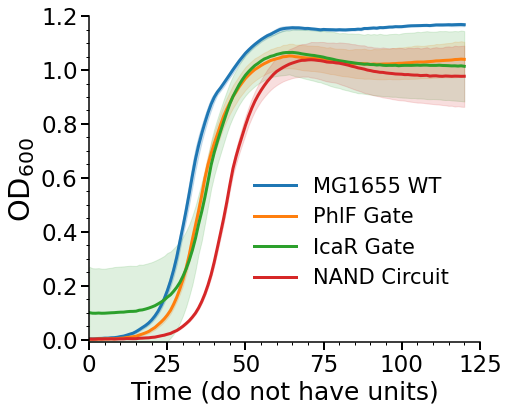

In [32]:
savefig = False

plt.figure(figsize=(7,6))
plt.plot(range(len(wt_mean)),wt_mean,label='MG1655 WT',lw=3) 
plt.fill_between(range(len(wt_mean)),wt_mean-wt_std,wt_mean+wt_std,alpha=0.2,color='tab:blue')
plt.plot(range(len(wt_mean)),phlf_mean,label='PhlF Gate',lw=3) 
plt.fill_between(range(len(wt_mean)),phlf_mean-phlf_std,phlf_mean+phlf_std,alpha=0.15,color='tab:orange')
plt.plot(range(len(wt_mean)),icar_mean,label='IcaR Gate',lw=3) 
plt.fill_between(range(len(wt_mean)),icar_mean-icar_std,icar_mean+icar_std,alpha=0.15,color='tab:green')
plt.plot(range(len(wt_mean)),nand_mean,label='NAND Circuit',lw=3 )
plt.fill_between(range(len(wt_mean)),nand_mean-nand_std,nand_mean+nand_std,alpha=0.15,color='tab:red')
plt.legend(frameon=False,fontsize=21,loc=(0.4,0.14))
plt.xlabel('Time (do not have units)',fontsize=25); plt.ylabel(r'OD$_{600}$',fontsize=29)
plt.ylim(-0.01,)
if savefig: 
    plt.savefig(figDir+'fig1/NANDiterate_gcs.pdf',bbox_inches='tight',transparent=True,dpi=300)
plt.show()

### Perform PCA -> kNN -> Leiden -> UMAP analysis

In [321]:
sc.pp.pca(bdata,n_comps=25)
sc.pp.neighbors(bdata,n_neighbors=50)
sc.tl.leiden(bdata,resolution=1) 
sc.tl.umap(bdata,min_dist=1.9) 

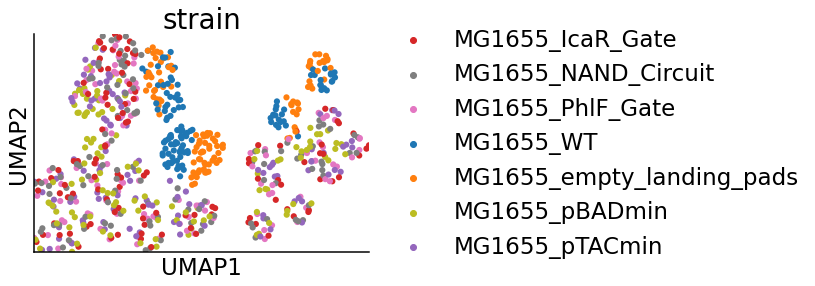

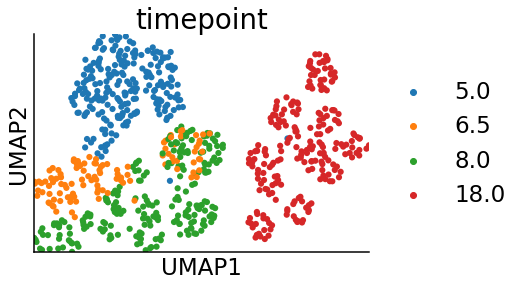

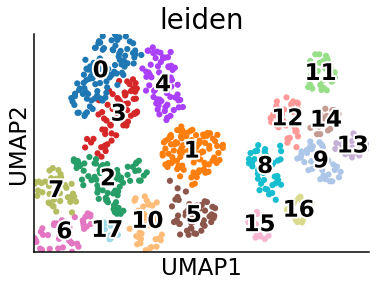

In [409]:
sc.pl.umap(bdata,color='strain',
           palette=['tab:red','tab:gray','tab:pink','tab:blue','tab:orange','tab:olive','tab:purple'],
          ) # save='_umap_by_strain.pdf'
sc.pl.umap(bdata,color='timepoint',palette=['tab:blue','tab:orange','tab:green','tab:red'],
          ) # save='_umap_by_time.pdf'
sc.pl.umap(bdata,color='leiden',legend_loc='on data',legend_fontoutline=4,legend_fontweight='heavy',
          ) # save='_umap_by_cluster.pdf'


### Differential expression between specified clusters

In [558]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['0'], reference='4', method='t-test',rankby_abs=True)

In [559]:
pvals_adj = -np.log10(np.array(bdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(bdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (bdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
ttest_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
ttest_df['pvals_adj'] = pvals_adj
ttest_df['logfcs'] = logfcs
ttest_df['names'] = names

pval_cutoff = -np.log10(0.05)
logfc_cutoff = 0.5

is_de = np.array((ttest_df['pvals_adj'] >= pval_cutoff) & (np.abs(ttest_df['logfcs']) >= logfc_cutoff))*1
ttest_df['is_de'] = is_de

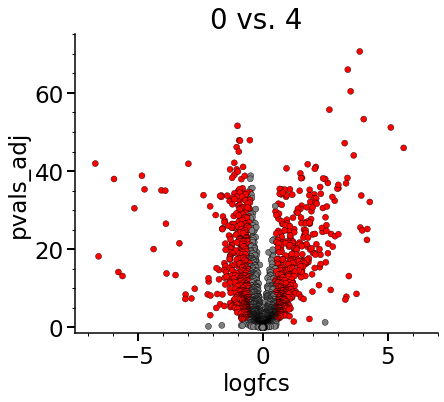

In [562]:
plt.figure(figsize=(6.5,5.5))
sns.scatterplot(x=ttest_df['logfcs'],y=ttest_df['pvals_adj'],hue=ttest_df['is_de'],legend=False,
                palette=['tab:grey','red'],edgecolor='k',linewidth=0.4)
plt.title('0 vs. 4')
plt.xlim(-7.5,7)
plt.ylim(-1.5,75)
plt.show()

In [563]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['6'], reference='1', method='t-test',rankby_abs=True)

In [564]:
pvals_adj = -np.log10(np.array(bdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(bdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (bdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
ttest_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
ttest_df['pvals_adj'] = pvals_adj
ttest_df['logfcs'] = logfcs
ttest_df['names'] = names

pval_cutoff = -np.log10(0.05)
logfc_cutoff = 0.5

is_de = np.array((ttest_df['pvals_adj'] >= pval_cutoff) & (np.abs(ttest_df['logfcs']) >= logfc_cutoff))*1
ttest_df['is_de'] = is_de

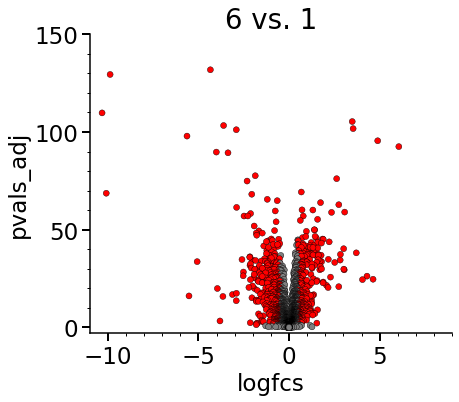

In [565]:
plt.figure(figsize=(6.5,5.5))
sns.scatterplot(x=ttest_df['logfcs'],y=ttest_df['pvals_adj'],hue=ttest_df['is_de'],legend=False,
                palette=['tab:grey','red'],edgecolor='k',linewidth=0.4)
plt.title('6 vs. 1')
plt.xlim(-11,9)
plt.ylim(-3,)
plt.show()

In [566]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['15'], reference='11', method='t-test',rankby_abs=True)

In [567]:
pvals_adj = -np.log10(np.array(bdata.uns['rank_genes_groups']['pvals_adj'].astype(np.float64)))
logfcs = np.array(bdata.uns['rank_genes_groups']['logfoldchanges'].astype(np.float64))
names = (bdata.uns['rank_genes_groups']['names'])
names = [gene[0] for gene in names.tolist()]
ttest_df = pd.DataFrame(columns=['pvals_adj','logfcs','names','is_de'])
ttest_df['pvals_adj'] = pvals_adj
ttest_df['logfcs'] = logfcs
ttest_df['names'] = names

pval_cutoff = -np.log10(0.05)
logfc_cutoff = 0.5

is_de = np.array((ttest_df['pvals_adj'] >= pval_cutoff) & (np.abs(ttest_df['logfcs']) >= logfc_cutoff))*1
ttest_df['is_de'] = is_de

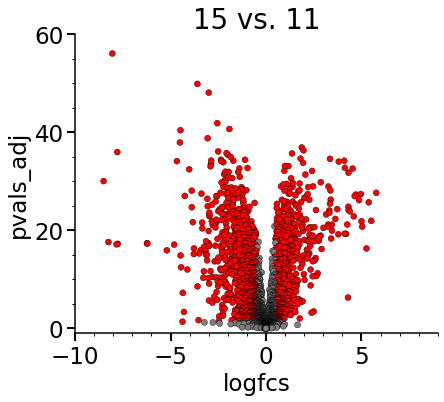

In [568]:
plt.figure(figsize=(6.5,5.5))
sns.scatterplot(x=ttest_df['logfcs'],y=ttest_df['pvals_adj'],hue=ttest_df['is_de'],legend=False,
                palette=['tab:grey','red'],edgecolor='k',linewidth=0.4)
plt.title('15 vs. 11')
plt.xlim(-10,9)
plt.ylim(-1,)
plt.show()

Compare (7 to 4), (3 to 0), (6 to 1)

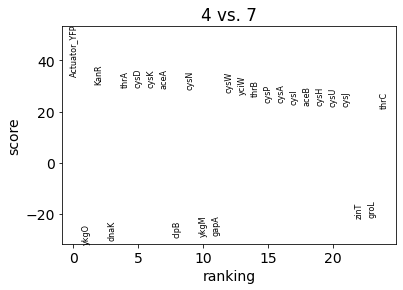

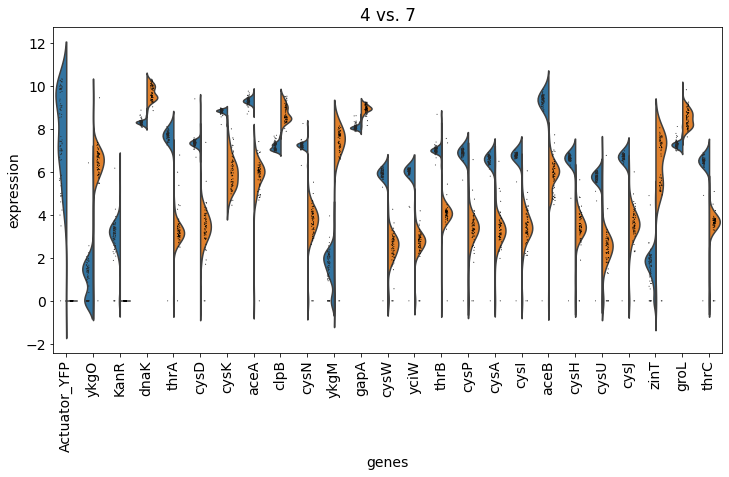

In [439]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['4'], reference='7', method='t-test',rankby_abs=True)
sc.pl.rank_genes_groups(bdata, groups=['4'], n_genes=25)
fig, ax = plt.subplots(figsize=(12,6))
sc.pl.rank_genes_groups_violin(bdata, groups=['4'], n_genes=25,ax=ax)

upregulation of cysteine synthesis as a stress response for survival? thrA and B also code for an amino acid synthase. Wondering if those amino acids are needed to handle the ribosomal translation process for the many heterologous transcripts that needs translating? or could it actually be a stress response? 

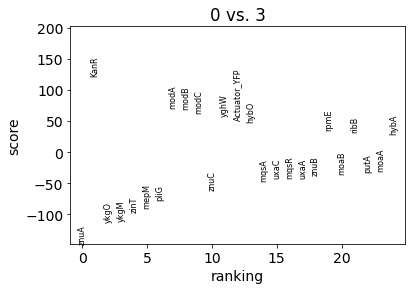

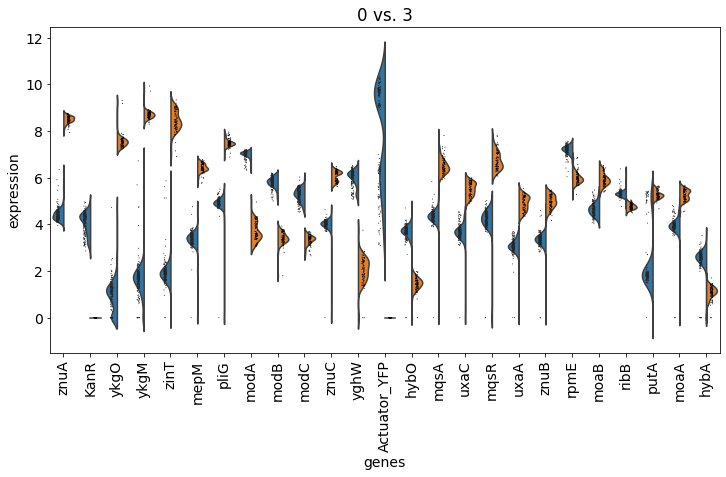

In [438]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['0'], reference='3', method='t-test',rankby_abs=True)
sc.pl.rank_genes_groups(bdata, groups=['0'], n_genes=25)
fig, ax = plt.subplots(figsize=(12,6))
sc.pl.rank_genes_groups_violin(bdata, groups=['0'], n_genes=25,ax=ax)

Why is molybdate important for expression of heterologous genes? Or this is yet another stress response? 

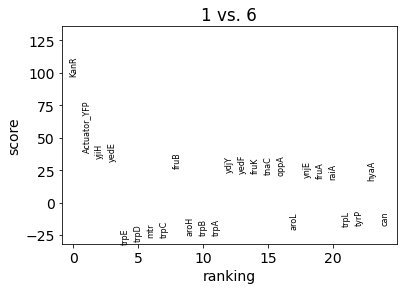

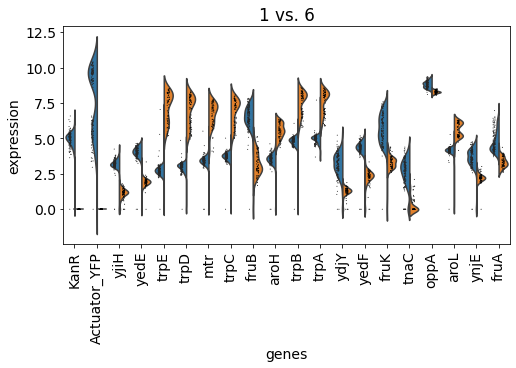

In [437]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['1'], reference='6', method='t-test',rankby_abs=True)
sc.pl.rank_genes_groups(bdata, groups=['1'], n_genes=25)
fig, ax = plt.subplots(figsize=(12,6))
sc.pl.rank_genes_groups_violin(bdata, groups=['1'], n_genes=25,ax=ax)

### Early timepoint comparison between WT/empty strains (reference) and genomic circuit strains (groups)

In [602]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['1'], reference='6', method='t-test',rankby_abs=True)

In [603]:
names = pd.DataFrame(bdata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(bdata.uns['rank_genes_groups']['scores'])
logfoldchanges = pd.DataFrame(bdata.uns['rank_genes_groups']['logfoldchanges'])
pvals_adj = pd.DataFrame(bdata.uns['rank_genes_groups']['pvals_adj'])
score_df = pd.concat((names,scores,logfoldchanges,pvals_adj),axis=1)
score_df.columns = ['gene','score','logfoldchanges','pvals_adj']


sig_df = score_df[(np.abs(score_df.logfoldchanges) >= 0.5) 
                                                & (score_df.pvals_adj <= 0.05)]

sig_essential_df = sig_df[sig_df.gene.isin(essential_genes)]

In [604]:
f'Out of {len(sig_df)} differentially expressed genes, {len(sig_essential_df)} are essential'

'Out of 1041 differentially expressed genes, 123 are essential'

In [605]:
sig_essential_df.head(10)

,gene,score,logfoldchanges,pvals_adj
1,yedE,41.078629,3.314269,3.083791e-61
7,aroH,-27.414913,-2.892639,4.488975e-40
22,hyaA,20.778769,1.504693,5.608130e-37
23,asnS,-20.451271,-0.889162,2.814984e-48
32,glyA,-18.589573,-0.819664,6.006341e-43
39,can,-18.204159,-0.975370,5.040128e-35
47,mtfA,17.816946,0.837279,2.829798e-38
65,oppD,16.774487,0.559038,3.849567e-28
91,murJ,-15.997957,-0.847657,1.796407e-28
97,thyA,-15.763869,-0.573124,6.385352e-34


essential or nonessential gene dysregulation


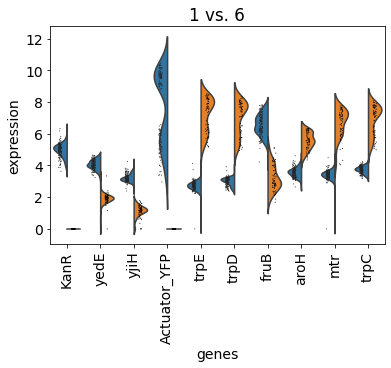

essential gene dysregulation


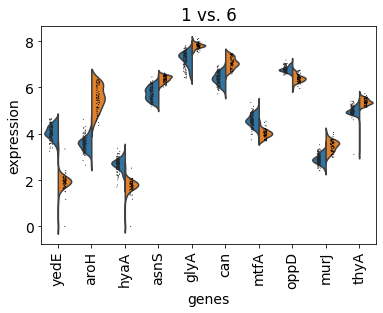

In [606]:
print('essential or nonessential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_df.gene.tolist()[:10], groups=['1'])
print('essential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_essential_df.gene.tolist()[:10], groups=['1'])

yedE (https://biocyc.org/gene?orgid=GCF_005221865&id=C9E45_RS10890-MONOMER) is a selenium transporter (putative). or uncharacterized transporter (predicted to be a transporter by computational analysis)

aroH (https://www.uniprot.org/uniprotkb/P00887/entry) is inhibited by trp and plays a role in chorismate biosynthesis. Interestingly, aroH was downregulated along with trp, indicating there may a TF that inhibits both. A regulonDB identifies no TF that regulates both aro and trp. 


In [638]:
### covariances of the differentially expressed genes in each cluster
cluster_covs = {}
for cluster in bdata.obs['leiden'].cat.categories.tolist(): 
    cdata = bdata[bdata.obs['leiden'].isin([cluster]),sig_df.gene.tolist()].copy()
    cluster_covs[cluster] = np.cov(cdata.X.T)
del cdata


<Figure size 720x360 with 0 Axes>

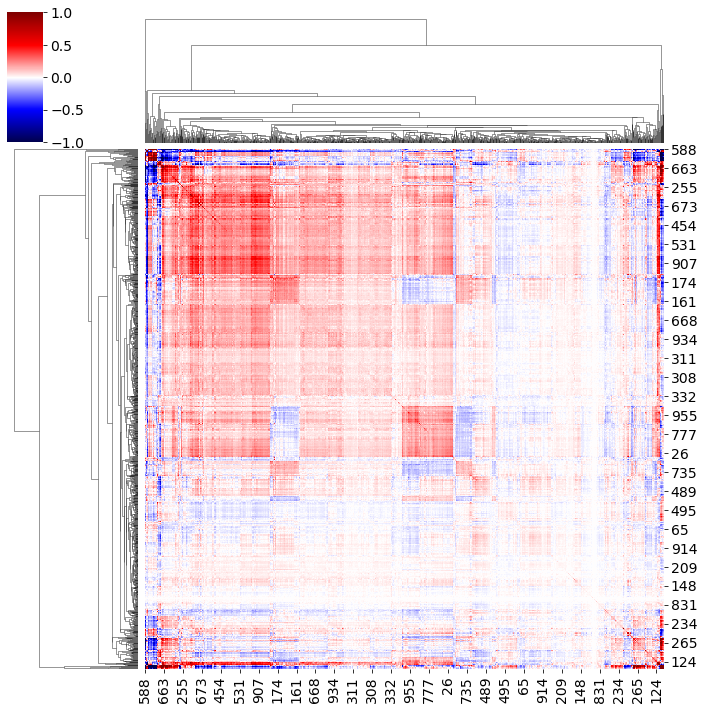

In [647]:
plt.figure(figsize=(10,5))
clustergrid = sns.clustermap(cluster_covs['2'],cmap='seismic',vmin=-1,vmax=1)
plt.show()

In [651]:
new_row_inds = clustergrid.dendrogram_row.reordered_ind
new_col_inds = clustergrid.dendrogram_col.reordered_ind

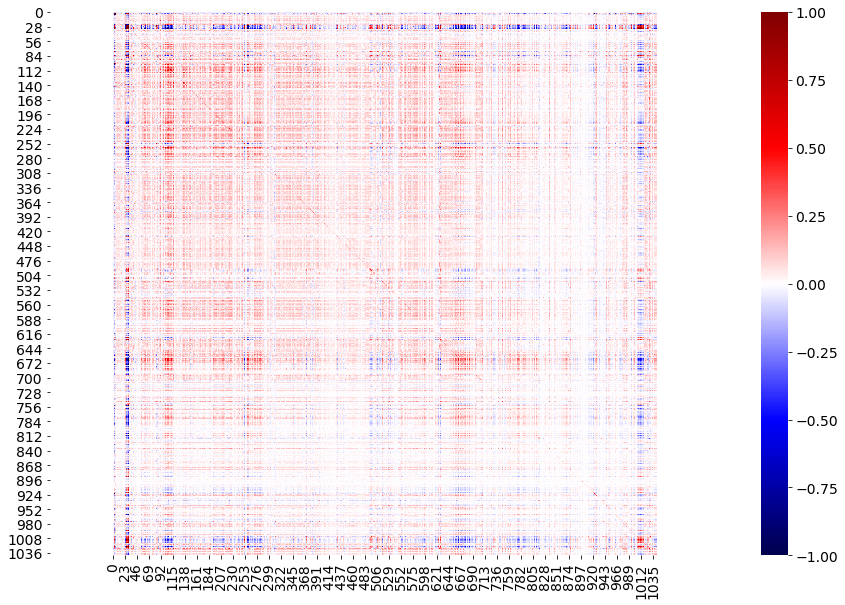

In [658]:
plt.figure(figsize=(15,10))
sns.heatmap(cluster_covs['0'][new_row_inds][:,new_col_inds],cmap='seismic',vmin=-1,vmax=1)
plt.axis('equal')
plt.show()

The covariance structure is obliterated by introduction of the circuits

In [663]:
np.linalg.norm(cluster_covs['0'] - cluster_covs['1'])

114.8052636306573

### Mid timepoint comparison between WT/empty strains (reference) and genomic circuit strains (groups)

In [697]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['0'], reference='2', method='t-test',rankby_abs=True)

In [698]:
names = pd.DataFrame(bdata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(bdata.uns['rank_genes_groups']['scores'])
logfoldchanges = pd.DataFrame(bdata.uns['rank_genes_groups']['logfoldchanges'])
pvals_adj = pd.DataFrame(bdata.uns['rank_genes_groups']['pvals_adj'])
score_df = pd.concat((names,scores,logfoldchanges,pvals_adj),axis=1)
score_df.columns = ['gene','score','logfoldchanges','pvals_adj']


sig_df = score_df[(np.abs(score_df.logfoldchanges) >= 0.5) 
                                                & (score_df.pvals_adj <= 0.05)]

sig_essential_df = sig_df[sig_df.gene.isin(essential_genes)]

In [699]:
f'Out of {len(sig_df)} differentially expressed genes, {len(sig_essential_df)} are essential'

'Out of 539 differentially expressed genes, 53 are essential'

essential or nonessential gene dysregulation


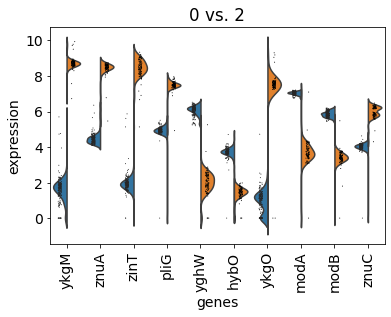

essential gene dysregulation


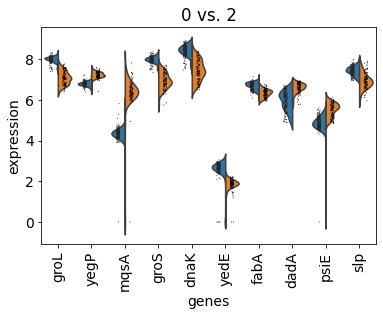

In [666]:
print('essential or nonessential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_df.gene.tolist()[:10], groups=['0'])
print('essential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_essential_df.gene.tolist()[:10], groups=['0'])

ykgM is most probabably a fill-in for a ribosomal subunit gene when zinc is not present in the environment. It is upregulated in zinc-deficient conditions and is repressed by the zinc uptake repressor zur. https://biocyc.org/gene?orgid=ECOLI&id=G6167

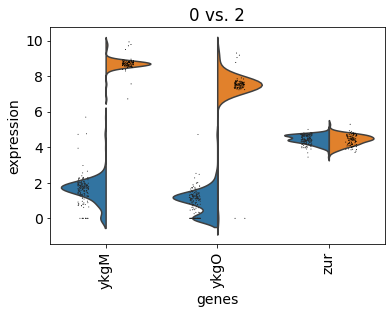

In [667]:
sc.pl.rank_genes_groups_violin(bdata,gene_names=['ykgM','ykgO','zur'], groups=['0'])

Very interesting that zur is not upregulated in the cluster 0. Though since we didn't measure the zinc concentration, we can't be sure that zur didn't cause the downregulation of ykgMO

groSL facilitate stress induced mutagenesis (SIM) in E. coli

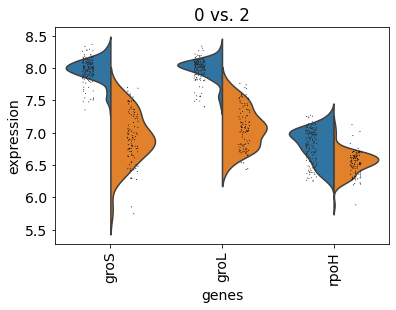

In [685]:
sc.pl.rank_genes_groups_violin(bdata,gene_names=['groS','groL','rpoH'], groups=['0'])

The groSL activation and slight upreuglation of rpoH (heat shock sigma factor) may represent a general stress response activation at this timepoint

### Late timepoint comparison between WT/empty strains (reference) and genomic circuit strains (groups)

There are two pairs of clusters for the later timepoint (7, 4) and (8, 5) 

#### First pair (7,4) (MID TO HIGH ARABINOSE)

In [707]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['4'], reference='7', method='t-test',rankby_abs=True)

In [708]:
names = pd.DataFrame(bdata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(bdata.uns['rank_genes_groups']['scores'])
logfoldchanges = pd.DataFrame(bdata.uns['rank_genes_groups']['logfoldchanges'])
pvals_adj = pd.DataFrame(bdata.uns['rank_genes_groups']['pvals_adj'])
score_df = pd.concat((names,scores,logfoldchanges,pvals_adj),axis=1)
score_df.columns = ['gene','score','logfoldchanges','pvals_adj']


sig_df = score_df[(np.abs(score_df.logfoldchanges) >= 0.5) 
                                                & (score_df.pvals_adj <= 0.05)]

sig_essential_df = sig_df[sig_df.gene.isin(essential_genes)]

In [709]:
f'Out of {len(sig_df)} differentially expressed genes, {len(sig_essential_df)} are essential'

'Out of 1993 differentially expressed genes, 311 are essential'

essential or nonessential gene dysregulation


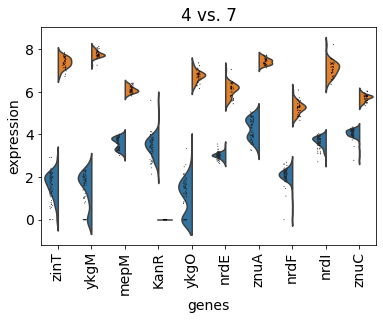

essential gene dysregulation


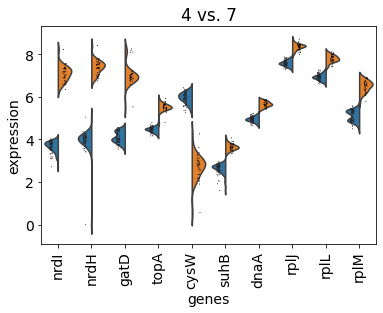

In [710]:
print('essential or nonessential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_df.gene.tolist()[:10], groups=['4'])
print('essential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_essential_df.gene.tolist()[:10], groups=['4'])

ykgMO still heavily downregulated

zinT binds zinc and delivers it to ZnuA (zinc uptake system, stress-induced mutation related gene) under severe zinc shortage. Is there too much zinc in the circuit strain conditions? How? Or could this indicate a competition for zinc among cells? (single-cell :) ) https://biocyc.org/gene?orgid=ECOLI&id=G7061

A mepM mutant showed reduced sensitivity to ampicillin https://biocyc.org/gene?orgid=ECOLI&id=EG10013

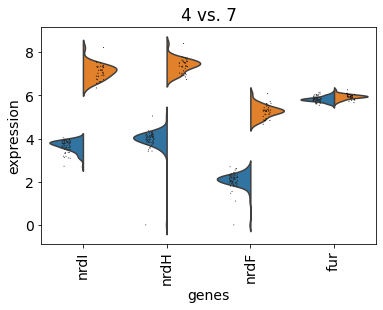

In [721]:
sc.pl.rank_genes_groups_violin(bdata,gene_names=['nrdI','nrdH','nrdF','fur'], groups=['4'])

#### Second pair (8,5) LOW ARABINOSE (MAYBE NONE)

In [728]:
sc.tl.rank_genes_groups(bdata, 'leiden', groups=['5'], reference='8', method='t-test',rankby_abs=True)

In [729]:
names = pd.DataFrame(bdata.uns['rank_genes_groups']['names'])
scores = pd.DataFrame(bdata.uns['rank_genes_groups']['scores'])
logfoldchanges = pd.DataFrame(bdata.uns['rank_genes_groups']['logfoldchanges'])
pvals_adj = pd.DataFrame(bdata.uns['rank_genes_groups']['pvals_adj'])
score_df = pd.concat((names,scores,logfoldchanges,pvals_adj),axis=1)
score_df.columns = ['gene','score','logfoldchanges','pvals_adj']


sig_df = score_df[(np.abs(score_df.logfoldchanges) >= 0.5) 
                                                & (score_df.pvals_adj <= 0.05)]

sig_essential_df = sig_df[sig_df.gene.isin(essential_genes)]

In [730]:
f'Out of {len(sig_df)} differentially expressed genes, {len(sig_essential_df)} are essential'

'Out of 3209 differentially expressed genes, 462 are essential'

essential or nonessential gene dysregulation


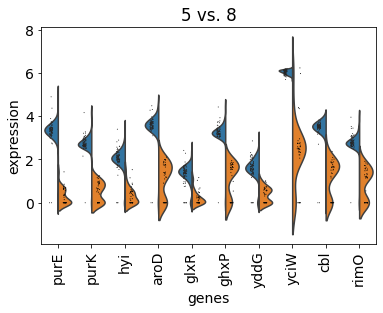

essential gene dysregulation


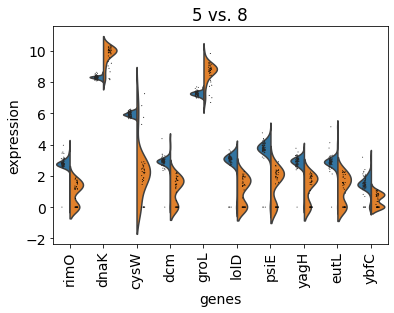

In [731]:
print('essential or nonessential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_df.gene.tolist()[:10], groups=['5'])
print('essential gene dysregulation')
sc.pl.rank_genes_groups_violin(bdata,gene_names=sig_essential_df.gene.tolist()[:10], groups=['5'])

To tolerate the increase in L-cysteine (cysW, etc.), the circuit strains also increased yciW, which has been shown to result in tolerance of increased L-cysteine https://biocyc.org/gene?orgid=ECOLI&id=G6640

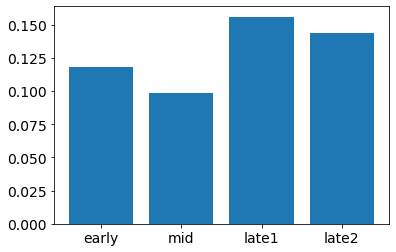

In [727]:
### percent of differentially expressed genes that are essential by timepoint
per_diff_essential = [123/1041,53/539,311/1993,462/3209]
plt.bar(range(len(per_diff_essential)),per_diff_essential)
plt.xticks(range(len(per_diff_essential)),labels=['early','mid','late1','late2'])
plt.show()

### Correlate cysW (and potentially other amino acid synthase genes) with YFP

In [735]:
cdata = bdata[bdata.obs.leiden.isin(['1','3','0','4','5'])].copy()

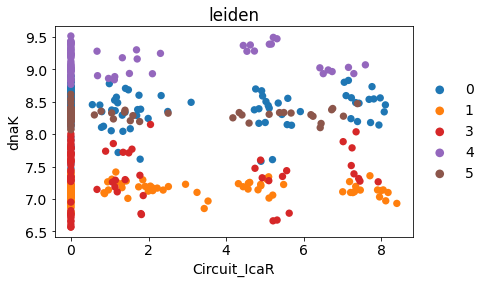

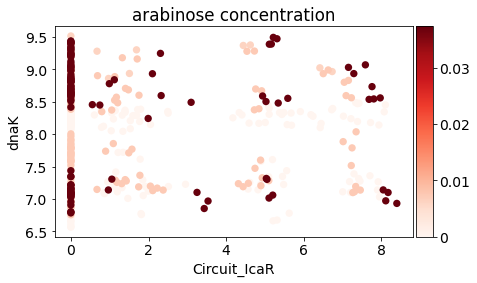

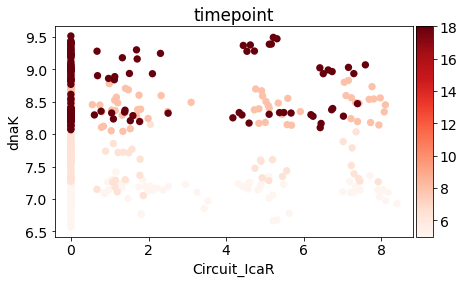

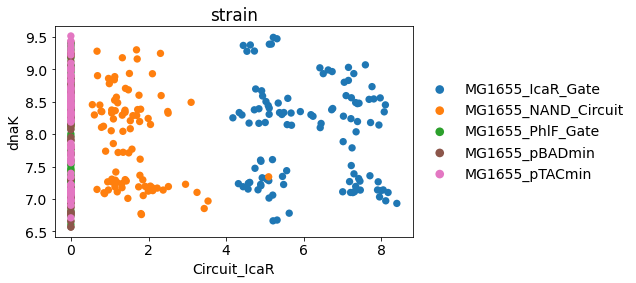

In [756]:
gene = 'dnaK'
circuit_part = 'Circuit_IcaR'
sc.pl.scatter(cdata,x=circuit_part,y=gene,color='leiden')
sc.pl.scatter(cdata,x=circuit_part,y=gene,color='arabinose_concentration',color_map='Reds')
sc.pl.scatter(cdata,x=circuit_part,y=gene,color='timepoint',color_map='Reds')
sc.pl.scatter(cdata,x=circuit_part,y=gene,color='strain',color_map='Reds')

It seems to not matter what the expression levels of YFP are. Differentially expressed genes are not really impacted

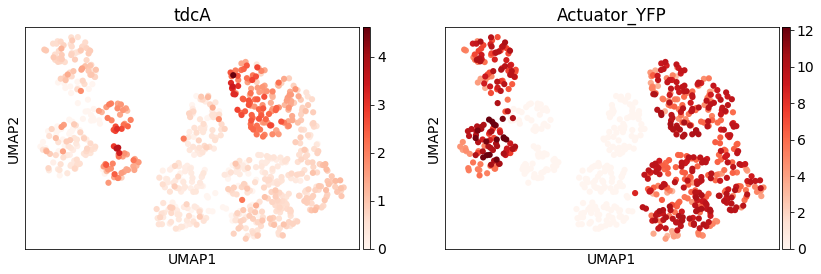

In [771]:
sc.pl.umap(bdata,color=['tdcA','Actuator_YFP'],cmap='Reds')